# Lecture notes

In this file you will find notes and scripts related to *[Mathematical Analysis of PWM Processes](https://eprints.nottingham.ac.uk/13021/1/Mathematical_Analysis_of_PWM_Processes.pdf)* by Gregory R. Ainslie-Malik from The University of Nottingham

# Introduction
## 1 Inverter design
* All inverter are supplied by an upper DC source of a prescribed voltage, and a lower DC source of a prescribed voltage.
* Three-phase inverters are commonly used for variable-frequency drive applications, which control the speed of an AC motor by adjusting the frequency of the electrical power supply.

## 1.2 PWM Methods
* PWM is a  high-frequency modulation strategy, made feasible by transistor, which can operate at the required high frequencies.
* PWM generates a square wave that switches between two values at a high frequencies, modulating the width of the pulses

![PWM parts][pwm parts]
![Sinusoidal PWM: (a) triangular carrier wave and sinusoidal reference signal, (b) gate pulse signal][pwm parts2]

* The square wave is constructed to have low-frequency components that provide a good approximation to the signal wave. In order to achieve this, the switch times of the square wave are determined by samples of the signal wave.
* There are two common sampling methods, known as *uniform* (or *regular*) and *natural* sampling. PWM inverters use both uniform and natural sampling.
    * Samples of the signal wave are taken at fixed intervals when using uniform sampling

![Uniform sampling and Natural sampling comparison][uniform and natural sampling comparison]

* PWM square waves generated with natural sampling do not have any low-frequency distortion.
* Space vector modulation (SVM) is limited to inverters with three or more phase lages, and is shown to be advantegous because **SVM inverters generate lower current harmonics** compared to standard PWM inverters.
* Both natural and uniform sampling are used in SVM inverters, but because SVM is better suited to digital devices, uniform sampling is more common

[pwm parts]: media/pwm%20parts.jpg
[pwm parts2]: media/Sinusoidal-PWM-a-triangular-carrier-wave-and-sinusoidal-reference-signal-b-gate.png
[uniform and natural sampling comparison]: media/uniform%20and%20natural%20sampling.PNG

## 1.3 Identification of High-Frequency Components Generated by PWM Inverters
* High-frequency components are also generated in the inputs and outputs of inverters by the load impedance
### 1.3.1 Calculations of Output Voltages and Currents
The Poisson re-summation method involves writing the voltage output as a discrete switching function in the time domain, then taking a Fourier transform. Use of the Poisson re-summation formula then allows us to identify a Fourier series expression for the voltage output

# 2 Voltage Spectra for PWM Inverters

## 2.1 Introduction
Frequency spectra of the output voltages are used to quantify the deviation of the low-frequency components from the intended signal wave, and to identify the high-frequency components, which will ultimately be filtered out.

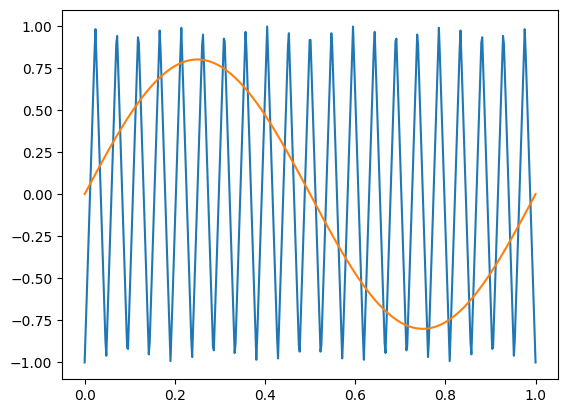

In [1]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt 

pi = np.pi

t = np.linspace(0,1,500)
ws = 1
wc = 21*ws
m = 0.8
triangle = signal.sawtooth(2*pi * wc *t ,0.5)
sine = m*np.sin(2*pi*ws*t)

plt.plot(t,triangle,t,sine)

## 2.2 Single-phase Inverter
Using PWM, high-frequency modulation of the swithces generates a voltage ouput, $v_{a}(t)$
Defining the signal $s_{a}\left(t\right)=M\cos{\left(\omega_{s} t\right)}$
Where $|M|<1$ is the modulation index, or (constant) amplitude, and $\omega_{s}$ is the frequency. In order to determine the switch times of $v_{a}(t)$, the signal wave is then sampled according to uniform sampling, or natural sampling.

In [2]:
from abc import abstractmethod


class Signal:
    def __init__(self,amplitude,frequency):
        self.amplitude = amplitude
        self.frequency = frequency
    
    @abstractmethod
    def output(self):
        pass

class SineSignal(Signal):
    
    def __init__(self,amplitude,frequency):
        Signal.__init__(self,amplitude,frequency)
    
    def output(self,input_signal):
        return self.amplitude * np.sin(self.frequency * input_signal)

class CarrierSignal(SineSignal):

    def __init__(self,frequency, amplitude=1, width =0.5):
        self.amplitude = amplitude
        self.frequency = frequency
        self.width = 0.5

    def output(self,t):
        return self.amplitude*signal.sawtooth(self.frequency*t ,self.width)
        

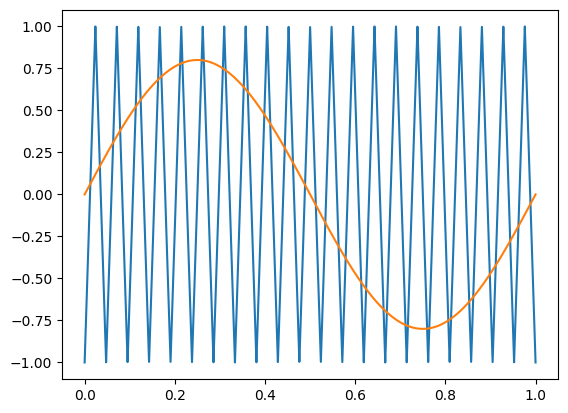

In [3]:
pi = np.pi


fs = 1
period = 1/fs

ws = 1
wc = 21*ws
m = 0.8

time_step = int(period*10000)

t = np.linspace(0,period,time_step)
carrier = CarrierSignal(2*pi*wc)
sine = SineSignal(m,ws*2*pi)

plt.plot(t,carrier.output(t),t,sine.output(t))

In this paper they use the following model to simulate the carrier signa. It is important to mention that this portion of the code will only be used to explain, but for the rest of the work I'll be using the carrier function showed above.

$$
w\left(t\right) =
    \begin{cases} 
        -1 +\frac{4(t−mT)}{T},& \text{for } mT < t < (m +\frac{1}{2})T, \\
        3 -\frac{4(t−mT)}{T} &  \text{for } (m +\frac{1}{2})T < t < (m +1)T
    \end{cases}
$$

Where $m$ is any integer and $T = 2π/ω_c$ is the switching period (and $ω_c > ω_s$ is the switching
frequency)

In [5]:
def calculate_manual_carrier(m,period,t):
    a = 1
    carrier = [lambda ti: -1+4*(ti-m*period)/period, lambda ti: 3-  4*(ti-m*period)/period]
    out = []
    m = 0
    for i in t:
        a += 1
        if t > m*period and t<(m+1/2)*period:
            out.append(carrier[0](i))
        elif t >= t<(m+1/2)*period and t<(m+1)*period:
            out.append(carrier[1](i))
        else:
            m += 1
            out.append(carrier[1](i))
    return out
manual_carrier=calculate_manual_carrier(0,period,t)
plt.plot(t,manual_carrier)

1.0
0.0
0.00010001000100010001
0.00020002000200020003
0.00030003000300030005
